# DM-38651: DC2 Reprocessing

An exercise in getting back up to speed on reprocessing data through the AP Pipeline, and using some of the newer APDB query utilities. The reprocessing was run on four patches of DC2 data in tract 4431. It happened on USDF via BPS and HTCondor in April 2023 with the latest weekly stack build at the time.

Note that the changes on DM-38960 are needed for this notebook to run properly.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
from typing import Mapping, cast
import functools
import operator

from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

In [3]:
import lsst.daf.butler as dafButler
import lsst.geom

In [4]:
from lsst.analysis.ap import legacyApdbUtils
from lsst.analysis.ap import apdb
from lsst.analysis.ap import legacyPlotUtils

In [5]:
repo = '/sdf/group/rubin/repo/dc2'
collections = 'u/mrawls/DM-38651/dc2-4patch_4431'
butler = dafButler.Butler(repo, collections=collections)

In [6]:
instrument = 'LSSTCam-imSim'
skymap = 'dc2'
schema = 'mrawls_dm38651_dc2'  # postgres schema is also known as namespace

In [7]:
apdbQuery = apdb.ApdbPostgresQuery(butler=butler, instrument=instrument, namespace=schema)

In [8]:
objTable = apdbQuery.load_objects()

In [9]:
srcTable = apdbQuery.load_sources()

In [10]:
objTable

diaObjectId              validityStart validityEnd         ra   
0        1257927201521871 2026-12-07 01:57:24.211100        None  55.761233  \
1        1257927201521872 2022-01-04 03:00:04.425800        None  55.760552   
2        1257927201521873 2022-01-04 03:00:04.425800        None  55.760726   
3        1257927201521874 2022-01-04 03:00:04.425800        None  55.674091   
4        1257927201521876 2022-01-04 03:00:04.425800        None  55.762374   
...                   ...                        ...         ...        ...   
18531  662500331589992850 2026-12-30 04:42:10.012900        None  55.870368   
18532  662500331589992851 2026-12-30 04:42:10.012900        None  55.874279   
18533  662500331589992852 2026-12-30 04:42:10.012900        None  55.873483   
18534  662500331589992856 2026-12-30 04:42:10.012900        None  55.875783   
18535  662500331589992857 2026-12-30 04:42:10.012900        None  55.880158   

      raErr       decl declErr ra_decl_Cov      radecTai  pmRa  ...   
0      None -32.260529    None        None  61381.081530  None  ...  \
1      None -32.261493    None        None  59583.125051  None  ...   
2      None -32.262494    None        None  59583.125051  None  ...   
3      None -32.283838    None        None  59583.125051  None  ...   
4      None -32.274793    None        None  59583.125051  None  ...   
...     ...        ...     ...         ...           ...   ...  ...   
18531  None -32.533464    None        None  61404.195949  None  ...   
18532  None -32.529103    None        None  61404.195949  None  ...   
18533  None -32.531882    None        None  61404.195949  None  ...   
18534  None -32.532148    None        None  61404.195949  None  ...   
18535  None -32.526614    None        None  61404.195949  None  ...   

      yPSFluxMax yPSFluxStetsonJ yPSFluxLinearSlope yPSFluxLinearIntercept   
0            NaN             NaN                NaN                    NaN  \
1            NaN             NaN                NaN                    NaN   
2            NaN             NaN                NaN                    NaN   
3            NaN             NaN                NaN                    NaN   
4            NaN             NaN                NaN                    NaN   
...          ...             ...                ...                    ...   
18531        NaN             NaN                NaN                    NaN   
18532        NaN             NaN                NaN                    NaN   
18533        NaN             NaN                NaN                    NaN   
18534        NaN             NaN                NaN                    NaN   
18535        NaN             NaN                NaN                    NaN   

      yPSFluxMaxSlope yPSFluxErrMean flags        lastNonForcedSource   
0                 NaN            NaN     0 2022-01-04 03:00:04.425800  \
1                 NaN            NaN     1 2022-01-04 03:00:04.425800   
2                 NaN            NaN     0 2022-01-04 03:00:04.425800   
3                 NaN            NaN     0 2022-01-04 03:00:04.425800   
4                 NaN            NaN     0 2022-01-04 03:00:04.425800   
...               ...            ...   ...                        ...   
18531             NaN            NaN     1 2026-12-30 04:42:10.012900   
18532             NaN            NaN     1 2026-12-30 04:42:10.012900   
18533             NaN            NaN     1 2026-12-30 04:42:10.012900   
18534             NaN            NaN     1 2026-12-30 04:42:10.012900   
18535             NaN            NaN     1 2026-12-30 04:42:10.012900   

      nDiaSources        pixelId  
0               1  9875799691557  
1               1  9875799695091  
2               1  9875799695331  
3               1  9875748785320  
4               1  9875799903746  
...           ...            ...  
18531           1  9871234788652  
18532           1  9871235621117  
18533           1  9871234819021  
18534           1  9871234765274  
18535        

In [11]:
# This is automatically set during query initialization
# Can override with a different set of bad flags if desired

#badFlagList=['base_PixelFlags_flag_bad',
#             'base_PixelFlags_flag_suspect',
#             'base_PixelFlags_flag_saturatedCenter',
#             'base_PixelFlags_flag_interpolated',
#             'base_PixelFlags_flag_interpolatedCenter',
#             'base_PixelFlags_flag_edge',
#            ]
#apdbQuery.set_excluded_diaSource_flags(badFlagList)

goodSrc = apdbQuery.load_sources(exclude_flagged=True)

In [12]:
goodObjIds = set(goodSrc['diaObjectId'])
goodObj = objTable.loc[objTable['diaObjectId'].isin(goodObjIds)]

Text(0.5, 1.0, 'DIA Objects composed of > 2 "Good" DIA Sources')

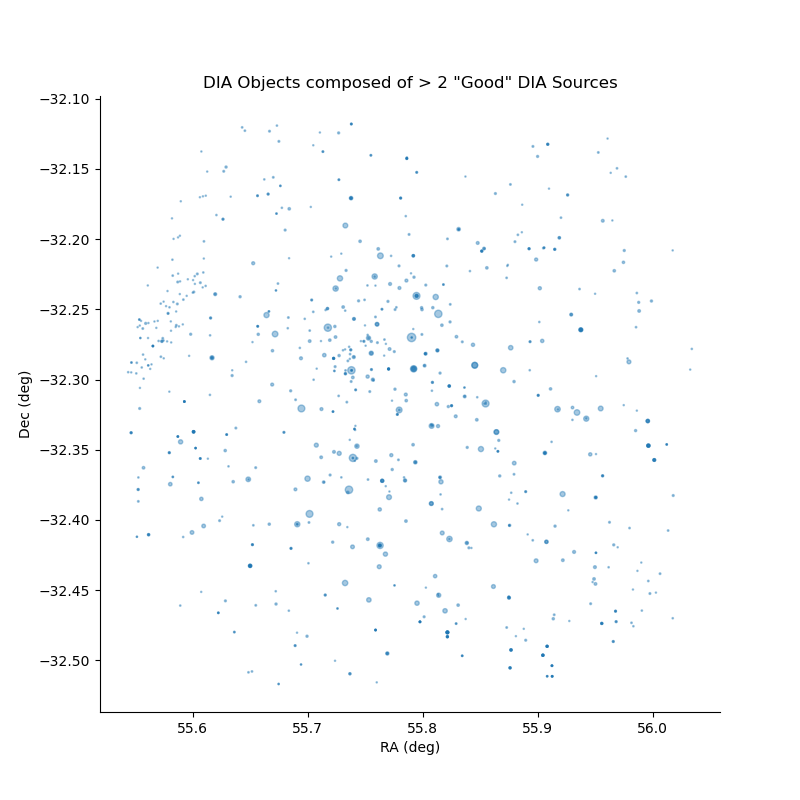

In [13]:
fig = plt.figure(figsize=(8,8))

cutoff = 2  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'], marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'DIA Objects composed of > {cutoff} "Good" DIA Sources')

In [14]:
print(len(goodObj), len(goodSrc))

8245 16922


In [15]:
print(len(objTable), len(srcTable))

18536 39277


### Old legacy way of loading all the things from the APDB

In [16]:
objTableLegacy, srcTableLegacy, goodObjLegacy, goodSrcLegacy = legacyApdbUtils.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsst-devl',
                                                      schema=schema,
                                                      instrument=instrument,
                                                      )

/tmp/ipykernel_24226/2701845272.py:1: FutureWarning: Call to deprecated function (or staticmethod) loadTables. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTableLegacy, srcTableLegacy, goodObjLegacy, goodSrcLegacy = legacyApdbUtils.loadTables(repo,
/home/m/mrawls/rubin-user/scipipe/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:250: FutureWarning: Call to deprecated function (or staticmethod) loadAllApdbObjects. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  objTable = loadAllApdbObjects(dbPath, dbType=dbType,
/home/m/mrawls/rubin-user/scipipe/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:483: FutureWarning: Call to deprecated function (or staticmethod) connectToApdb. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  connection = connectToApdb(dbNam

In [17]:
_, srcTableFlags, _, goodSrcLegacy, goodObjLegacy = legacyApdbUtils.makeSrcTableFlags(srcTableLegacy,
                                                                          objTableLegacy,
                                                                          repo=repo,
                                                                          instrument=instrument,)

/tmp/ipykernel_24226/1620692676.py:1: FutureWarning: Call to deprecated function (or staticmethod) makeSrcTableFlags. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  _, srcTableFlags, _, goodSrcLegacy, goodObjLegacy = legacyApdbUtils.makeSrcTableFlags(srcTableLegacy,
/home/m/mrawls/rubin-user/scipipe/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py:445: FutureWarning: Call to deprecated function (or staticmethod) addTableMetadata. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  addTableMetadata(sourceTable, butler=butler, instrument=instrument)


Text(0.5, 1.0, 'DIA Objects composed of > 2 "Good" DIA Sources')

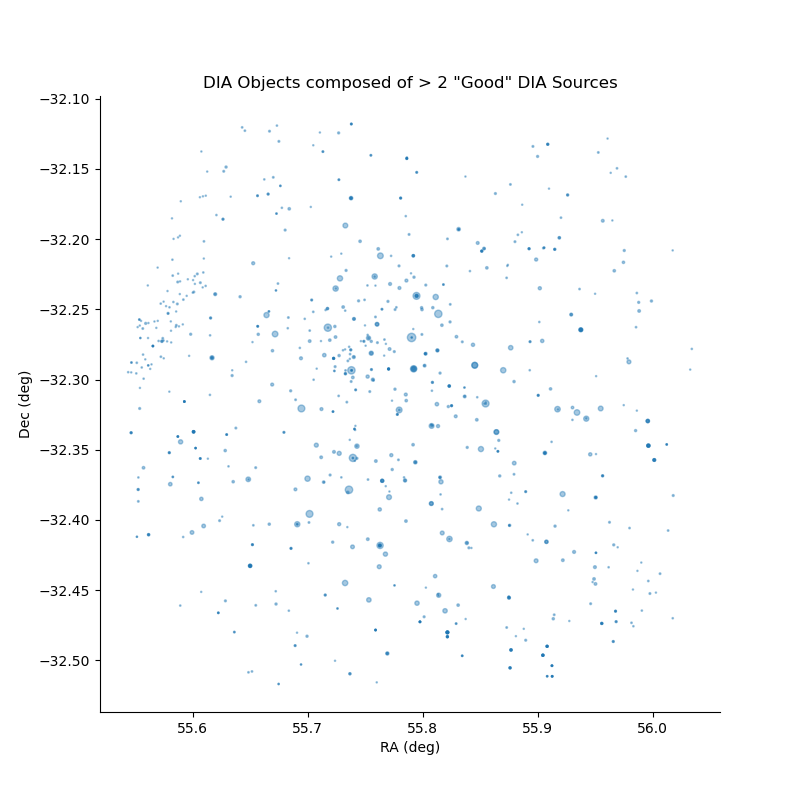

In [18]:
fig = plt.figure(figsize=(8,8))

#xlim = (151.05, 149.40)
#ylim = (1.45, 3.03)
cutoff = 2  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
#plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObjLegacy.loc[goodObjLegacy['nDiaSources'] > cutoff, 'ra'], goodObjLegacy.loc[goodObjLegacy['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObjLegacy.loc[goodObjLegacy['nDiaSources'] > cutoff, 'nDiaSources'], marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'DIA Objects composed of > {cutoff} "Good" DIA Sources')

In [19]:
print(len(goodObjLegacy), len(goodSrcLegacy))

8245 16922


In [20]:
print(len(objTableLegacy), len(srcTableLegacy))

18536 39277


## Some more plots

These all use `legacyPlotUtils` or are plotted directly in notebook cells, for now.

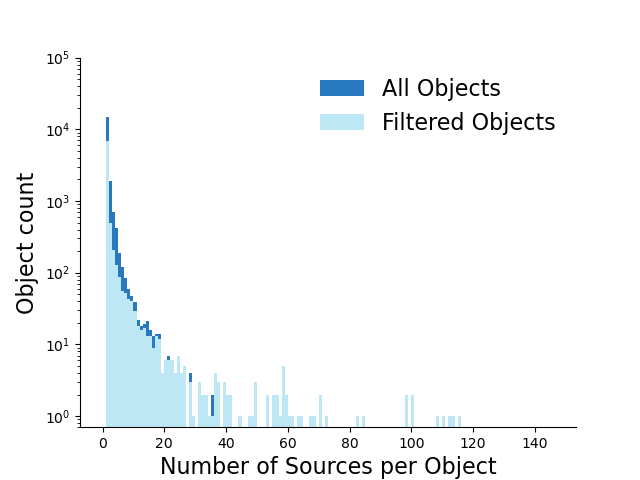

In [21]:
hist = legacyPlotUtils.plotDiaObjectHistogram(objTable, goodObj)

Text(0.5, 1.0, 'DIA Object and DIA Source counts')

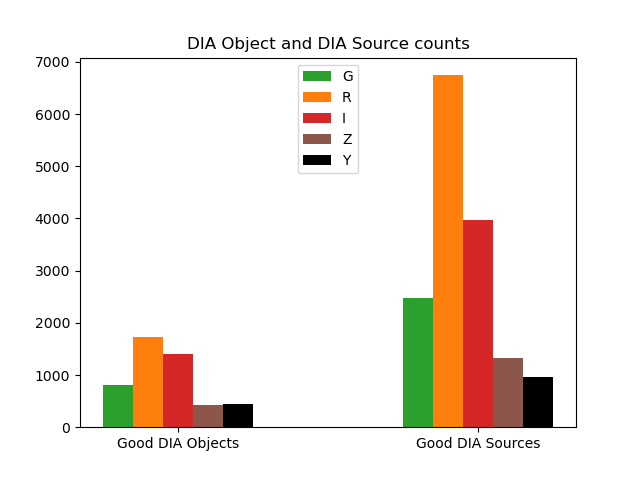

In [22]:
fig, ax = plt.subplots()
barLabels = ['Good DIA Objects', 'Good DIA Sources']
xbar = np.array([0, 1])
width = 0.2

goodObjG = goodObj.loc[goodObj['gPSFluxMean'] > 0]
goodObjR = goodObj.loc[goodObj['rPSFluxMean'] > 0]
goodObjI = goodObj.loc[goodObj['iPSFluxMean'] > 0]
goodObjZ = goodObj.loc[goodObj['zPSFluxMean'] > 0]
goodObjY = goodObj.loc[goodObj['yPSFluxMean'] > 0]

goodSrcG = goodSrc.loc[goodSrc['filterName'] == 'g']
goodSrcR = goodSrc.loc[goodSrc['filterName'] == 'r']
goodSrcI = goodSrc.loc[goodSrc['filterName'] == 'i']
goodSrcZ = goodSrc.loc[goodSrc['filterName'] == 'z']
goodSrcY = goodSrc.loc[goodSrc['filterName'] == 'y']

ax.bar(xbar - width, [len(goodObjG), len(goodSrcG)], width/2, label='G', color='C2')
ax.bar(xbar - width/2, [len(goodObjR), len(goodSrcR)], width/2, label='R', color='C1')
ax.bar(xbar, [len(goodObjI), len(goodSrcI)], width/2, label='I', color='C3')
ax.bar(xbar + width/2, [len(goodObjZ), len(goodSrcZ)], width/2, label='Z', color='C5')
ax.bar(xbar + width, [len(goodObjY), len(goodSrcY)], width/2, label='Y', color='k')

plt.legend(loc='upper center')
ax.set_xticks([0, 1])
labels = ax.set_xticklabels(barLabels)
plt.title('DIA Object and DIA Source counts')

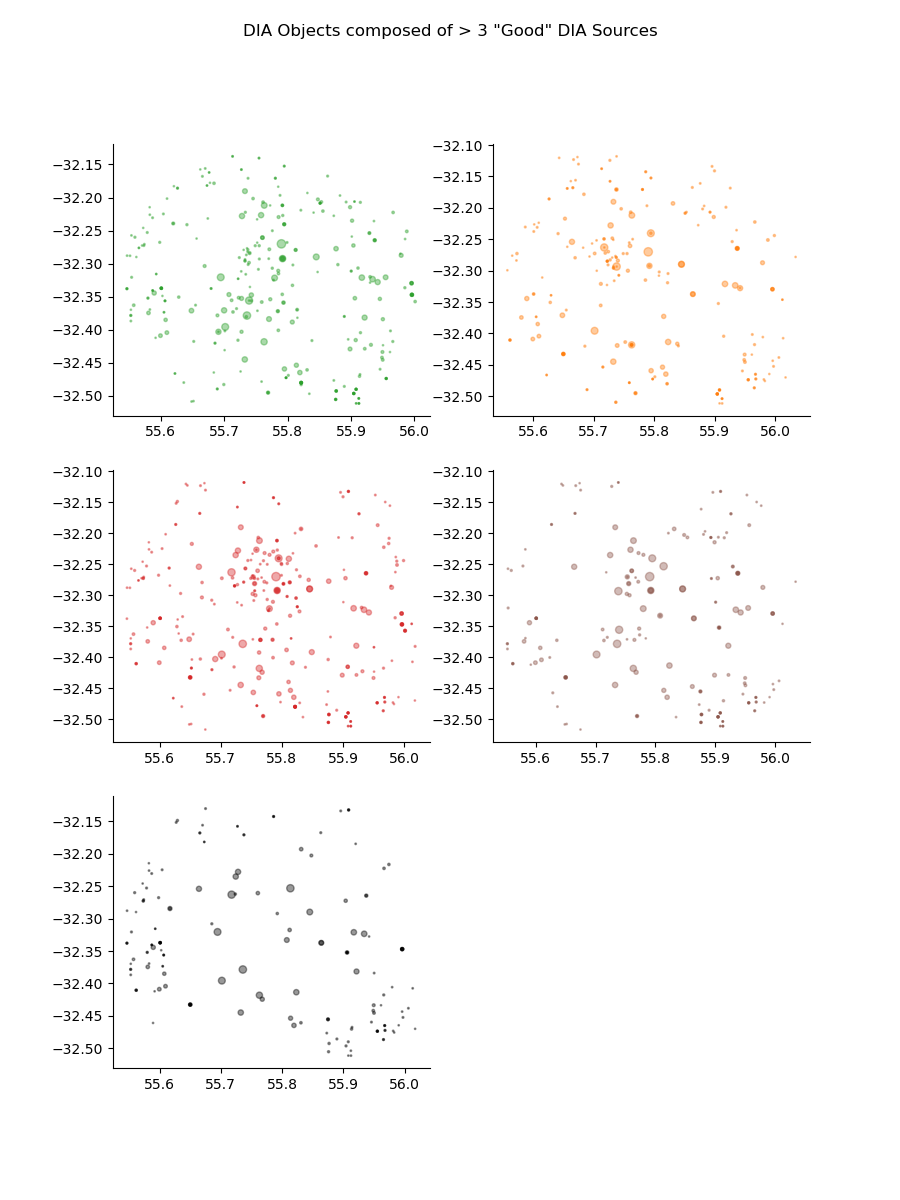

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(9, 12))

axG = axs[0, 0]
axR = axs[0, 1]
axI = axs[1, 0]
axZ = axs[1, 1]
axY = axs[2, 0]

ax0 = axs[2, 1]
ax0.axis('off')

axList = [axG, axR, axI, axZ, axY]
colorList = ['C2', 'C1', 'C3', 'C5', 'k']

### DIA OBJECTS ###

nSrc = 3  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)
fig.suptitle(f'DIA Objects composed of > {nSrc} "Good" DIA Sources')

goodGFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['gPSFluxMean'] > 0)
goodRFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['rPSFluxMean'] > 0)
goodIFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['iPSFluxMean'] > 0)
goodZFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['zPSFluxMean'] > 0)
goodYFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['yPSFluxMean'] > 0)

filterList = [goodGFilter, goodRFilter, goodIFilter, goodZFilter, goodYFilter]

for ax, filtered, color in zip(axList, filterList, colorList):
    ax.scatter(goodObj.loc[filtered, 'ra'], goodObj.loc[filtered, 'decl'], c=color, marker='.', alpha=0.4,
               s=goodObj.loc[(goodObj['nDiaSources'] > cutoff) & (filtered), 'nDiaSources'])


for ax in axList:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

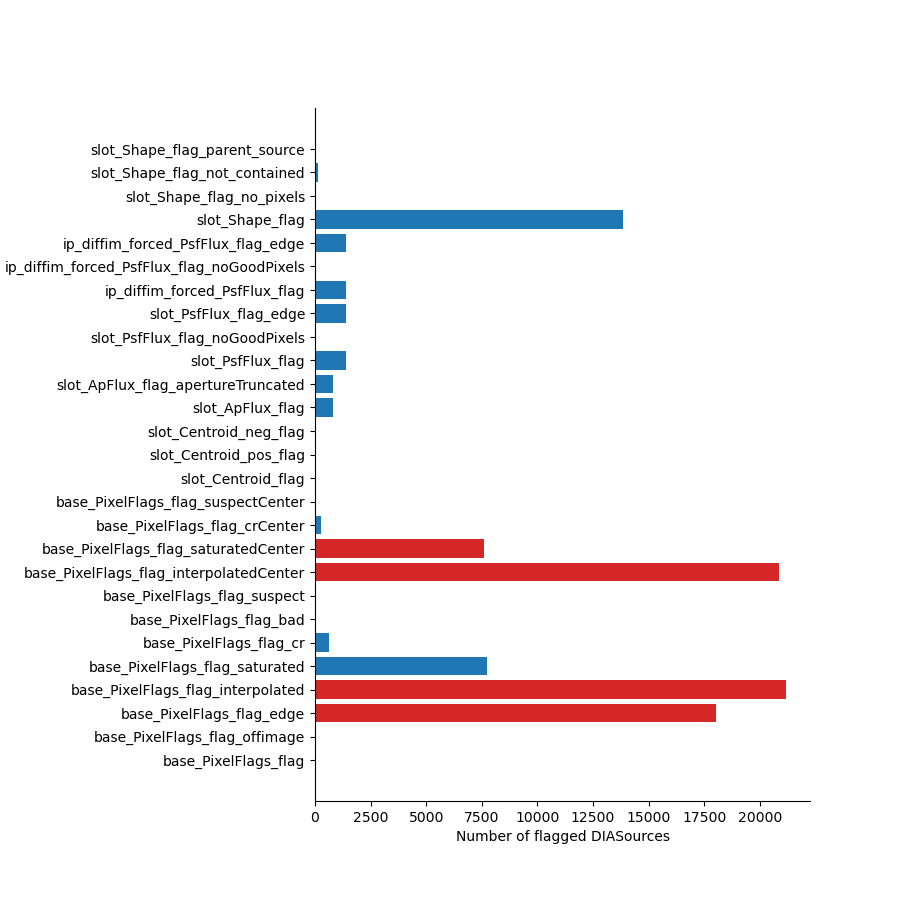

In [24]:
badFlagList=['base_PixelFlags_flag_bad',
             'base_PixelFlags_flag_suspect',
             'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_interpolated',
             'base_PixelFlags_flag_interpolatedCenter',
             'base_PixelFlags_flag_edge',
            ]
legacyPlotUtils.plotFlagHist(srcTable, badFlagList=badFlagList)

In [25]:
def spatial_flag_plot(df, flagName1, flagName2=None, operator=None, plotFlagged=True, plotUnFlagged=True, title=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    
    fig, ax = plt.subplots(figsize=(9,6))
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'decl'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'decl'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlim = (150.8, 149.8)
    #ylim = (2.4, 3.1)
    #plt.setp(ax, xlim=xlim, ylim=ylim)
    
    #ax.invert_xaxis()
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(bbox_to_anchor=(0.9, 0.9))
    
    plt.title(title)

Flagged sources: 21515
Unflagged sources: 17762


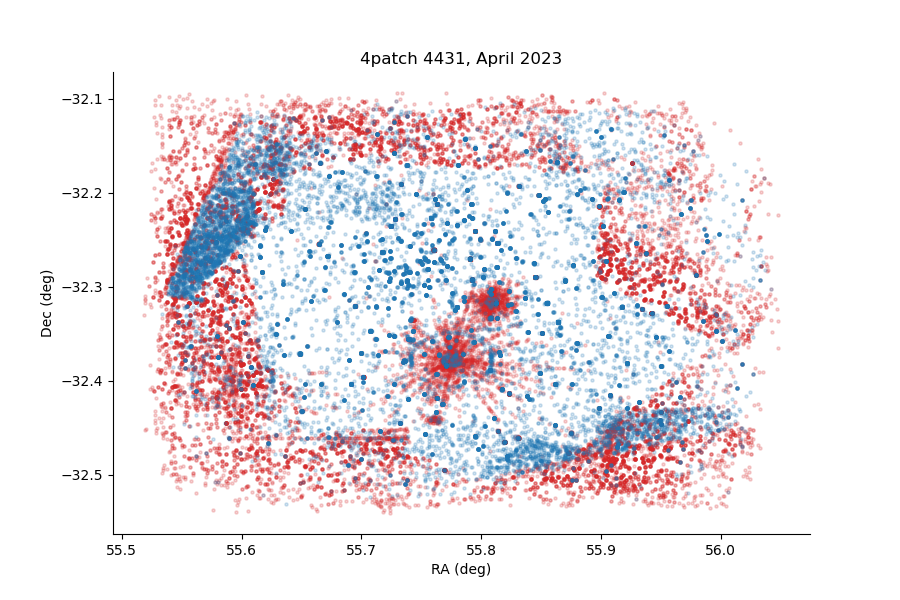

In [26]:
spatial_flag_plot(srcTableFlags, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated', operator='or',
                  title='4patch 4431, April 2023')

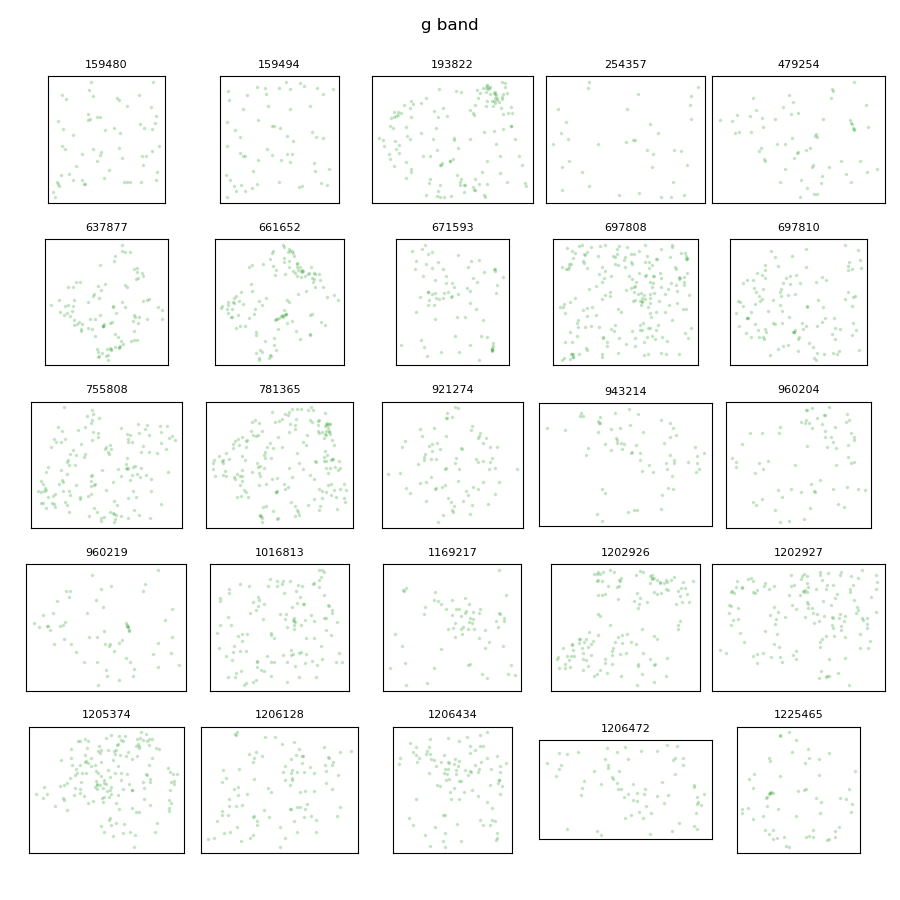

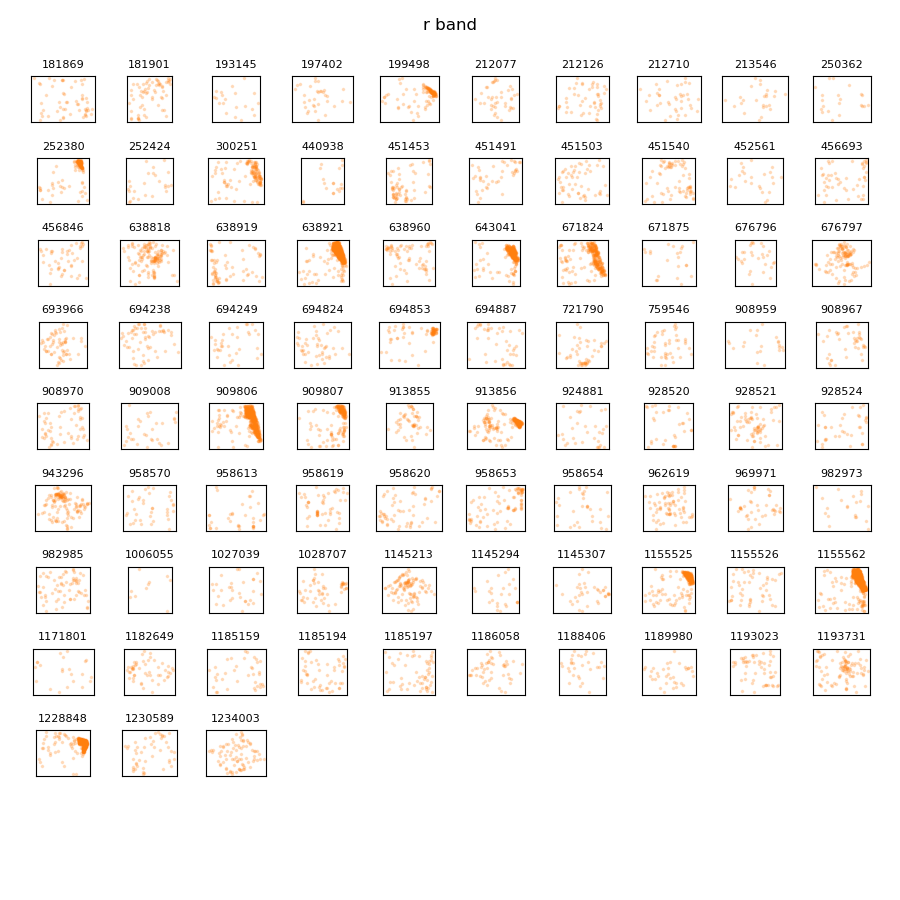

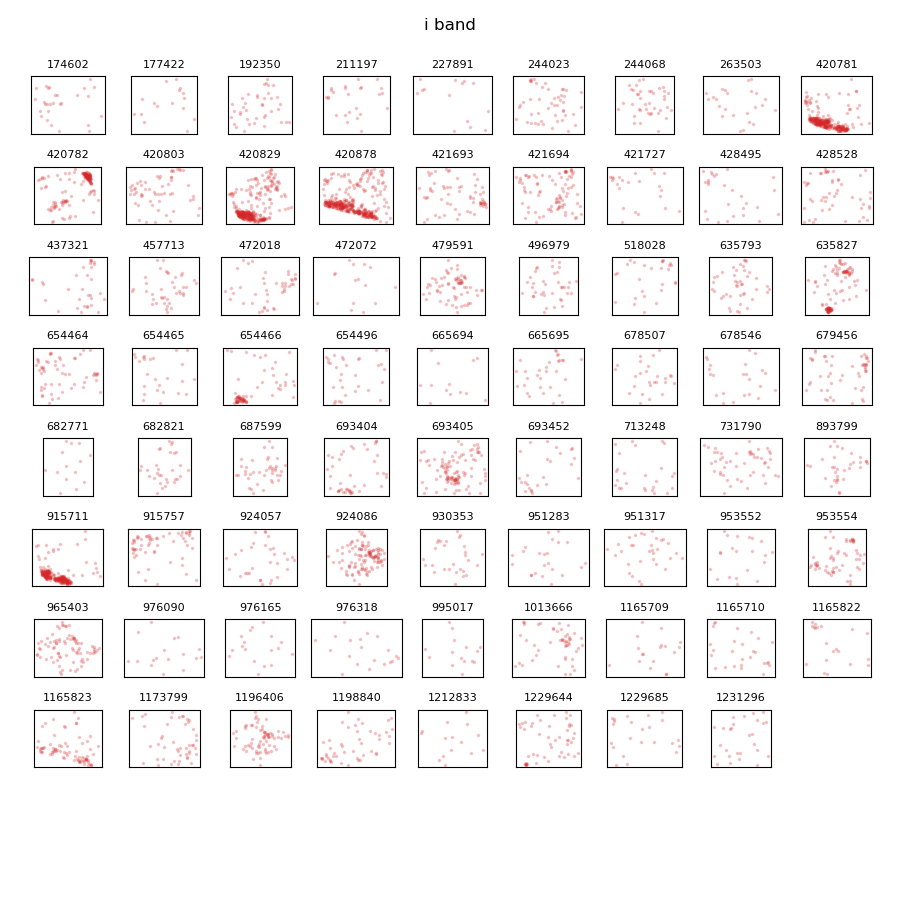

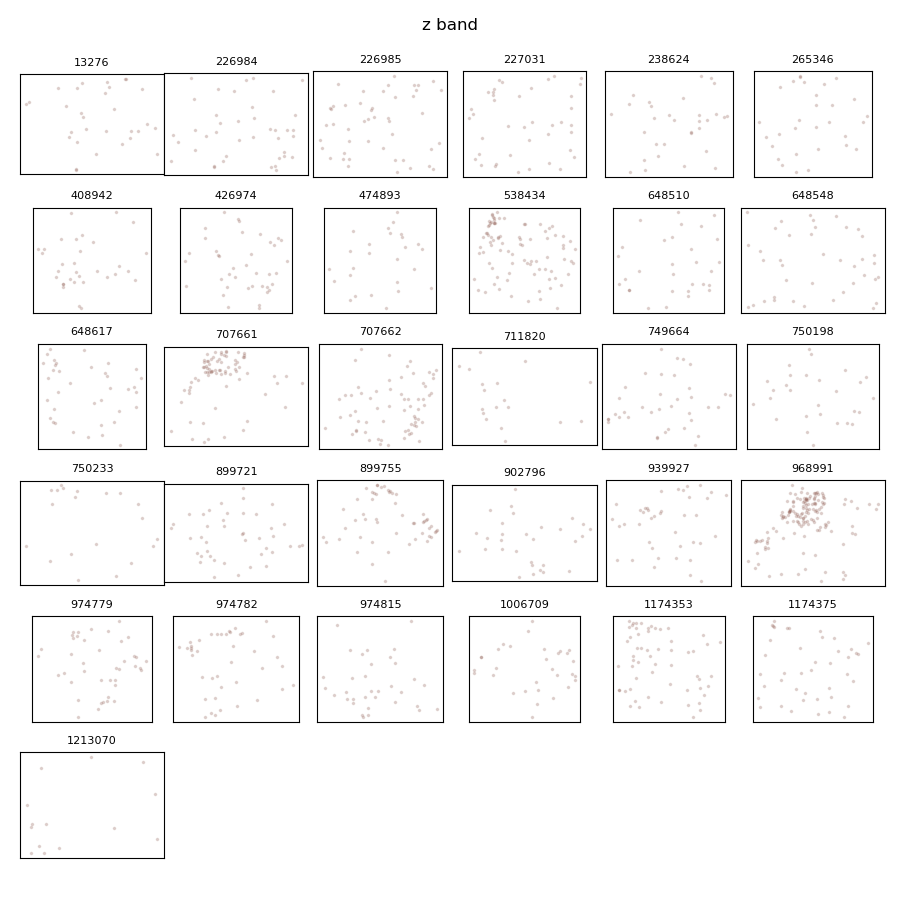

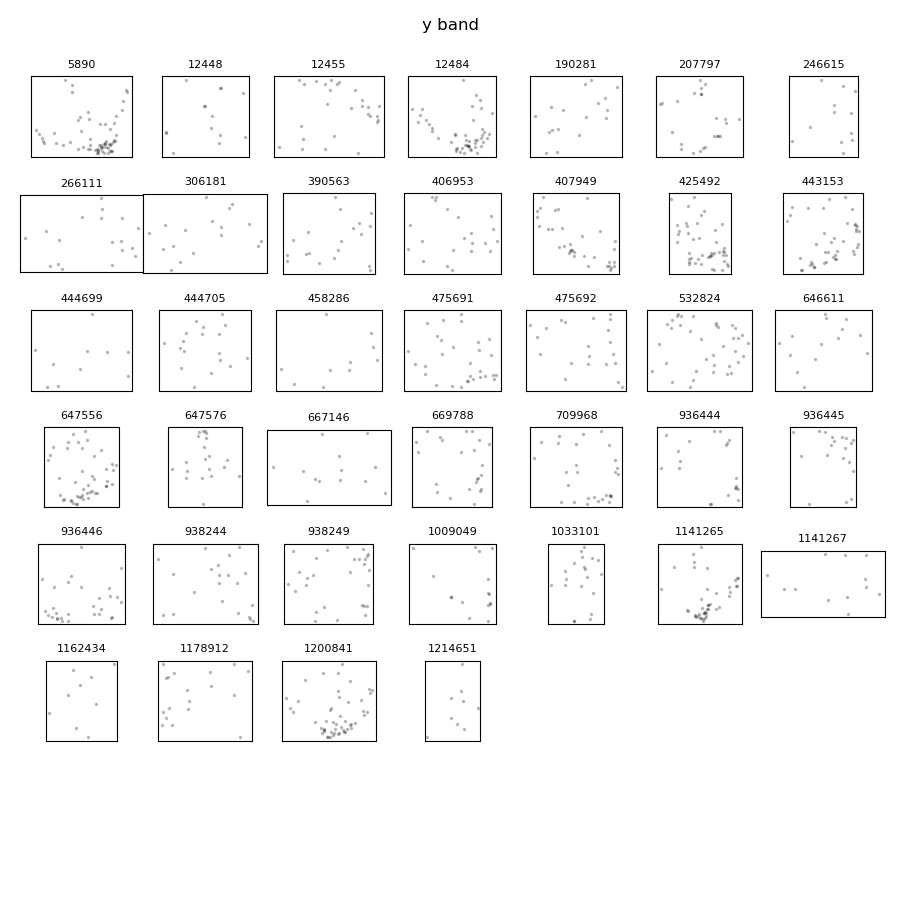

In [27]:
bandList = ['g', 'r', 'i', 'z', 'y']
colorList = ['C2', 'C1', 'C3', 'C5', 'k']
for band, color in zip(bandList, colorList):
    legacyPlotUtils.plotDiaSourcesOnSkyGrid(repo,
                                            goodSrc.loc[goodSrc['filterName'] == band],
                                            title=band+' band',
                                            color=color,
                                            size=10,)

g band DIA Sources
85620264850687483


/home/m/mrawls/rubin-user/scipipe/analysis_ap/python/lsst/analysis/ap/legacyPlotUtils.py:850: FutureWarning: Call to deprecated function (or staticmethod) loadExposures. (This method is deprecated and will be removed once the replacement API is in place.) -- Deprecated since version v24.
  science, difference, template = loadExposures(butler, dataId,


85620264850687486
85620264850687487
85620264850687490
85620264850687495
r band DIA Sources
97640275215646847
97640275215646848
97640275215646851
97640275215646852


/home/m/mrawls/rubin-user/scipipe/analysis_ap/python/lsst/analysis/ap/legacyPlotUtils.py:882: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)


97640275215646853
i band DIA Sources
93738742493216865
93738742493216869
93738742493216873
93738742493216876
93738742493216879
z band DIA Sources
7127535271805019
7127535271805022
7127535271805030
7127535271805031
7127535271805032
y band DIA Sources
3162235706802269
3162235706802271
3162235706802272
3162235706802274
3162235706802275


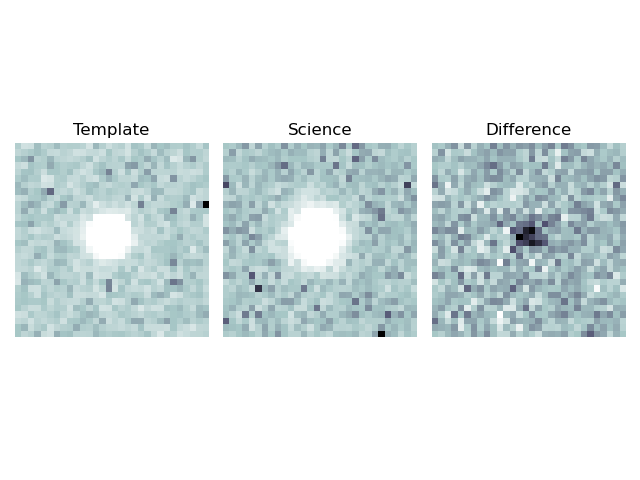

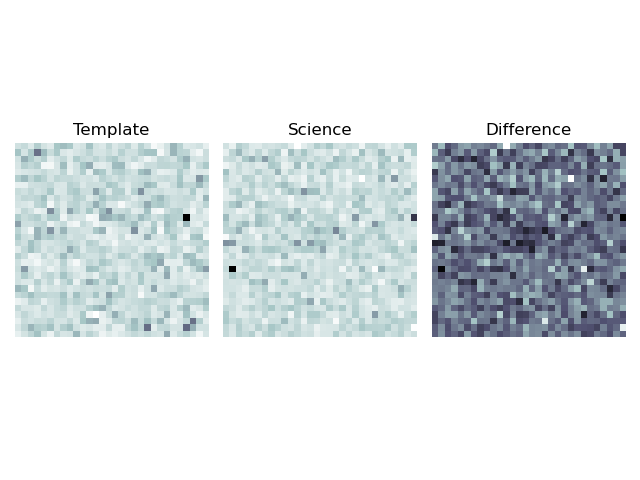

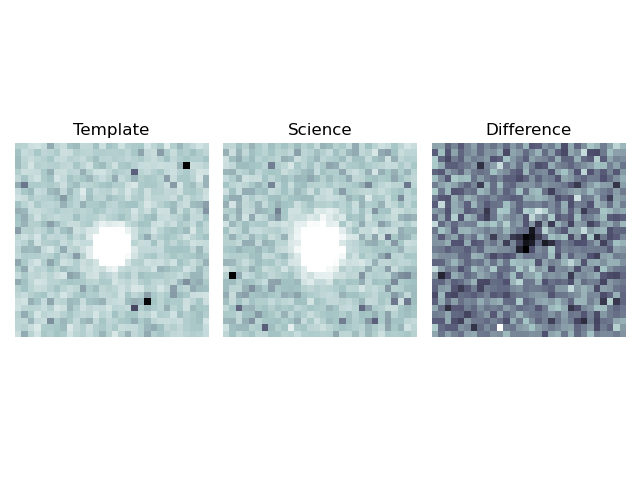

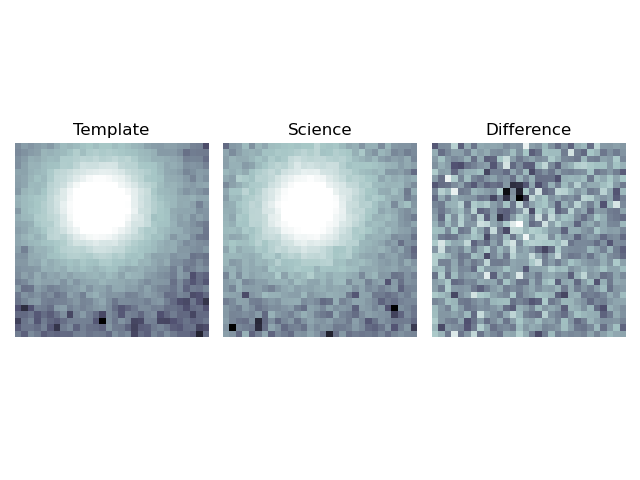

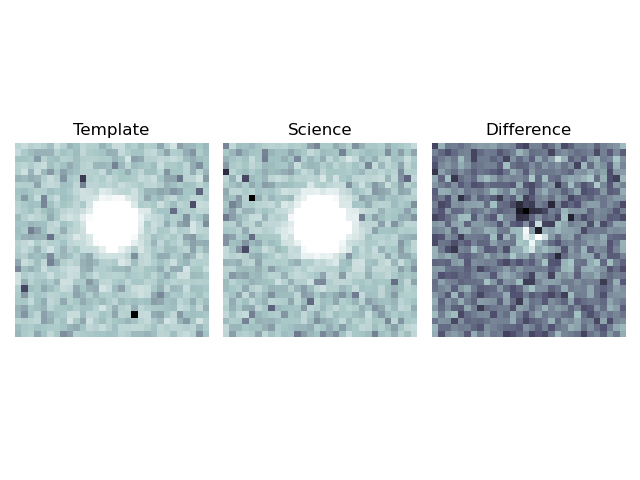

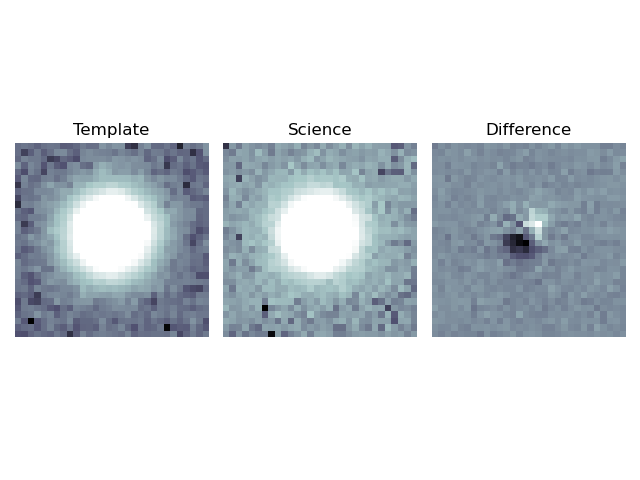

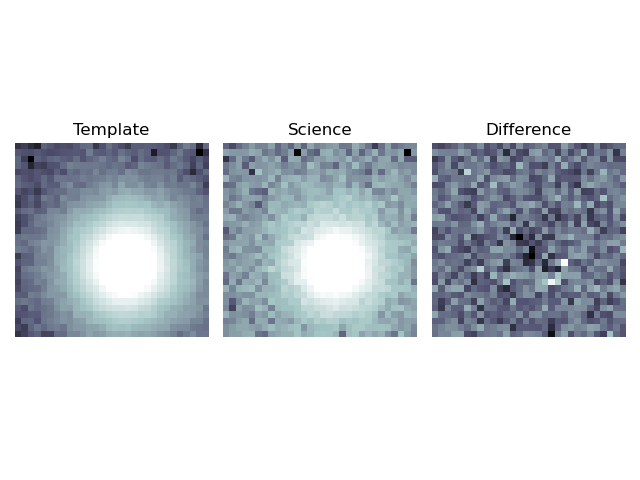

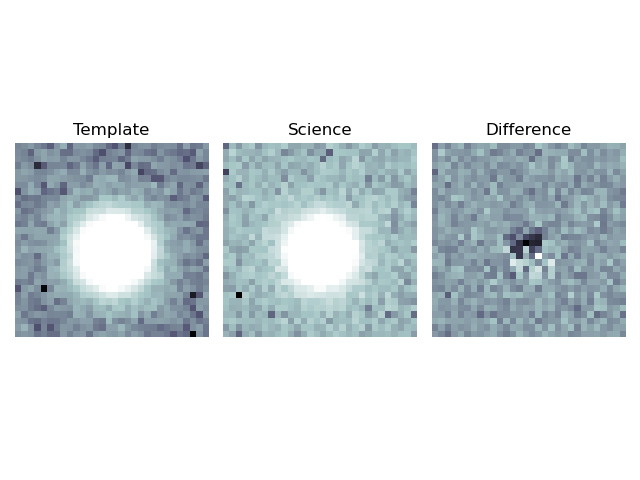

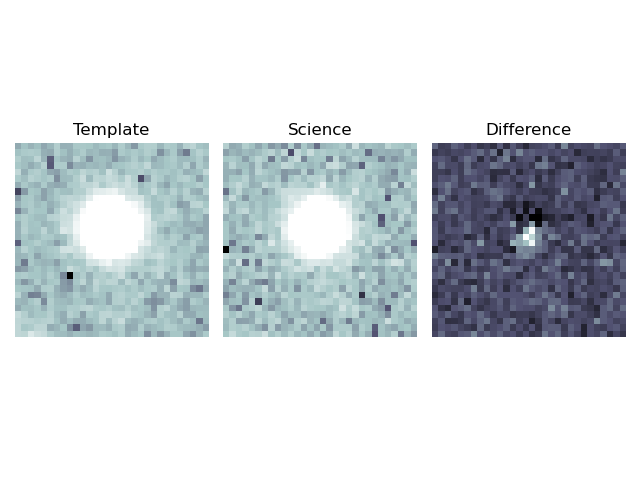

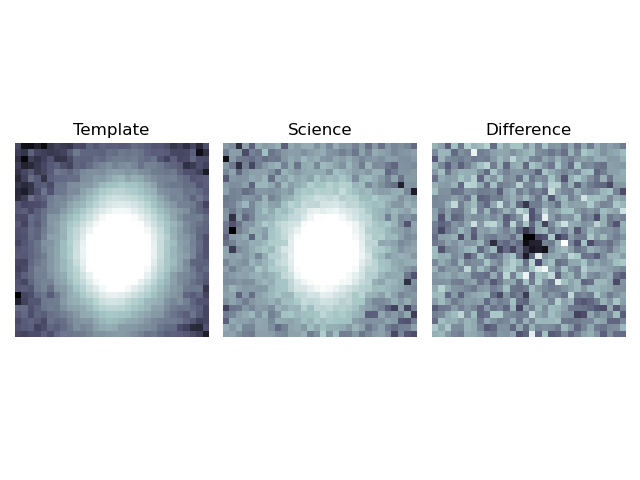

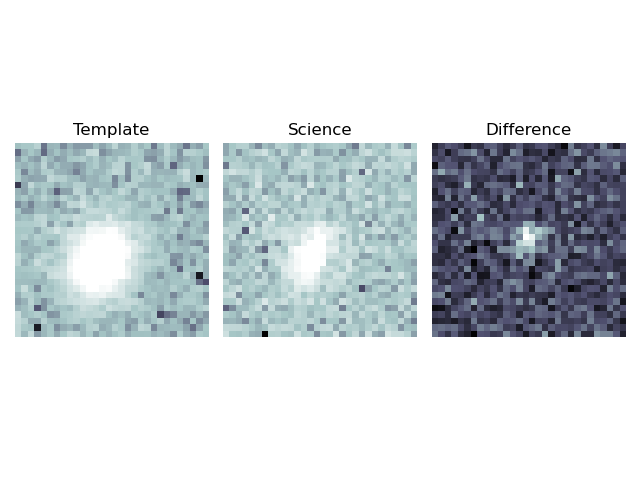

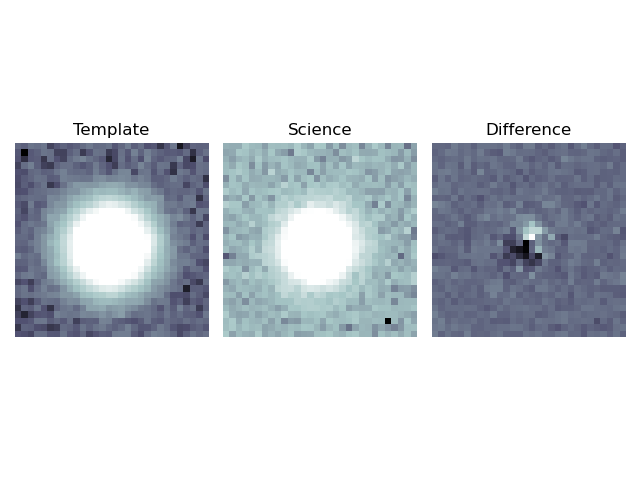

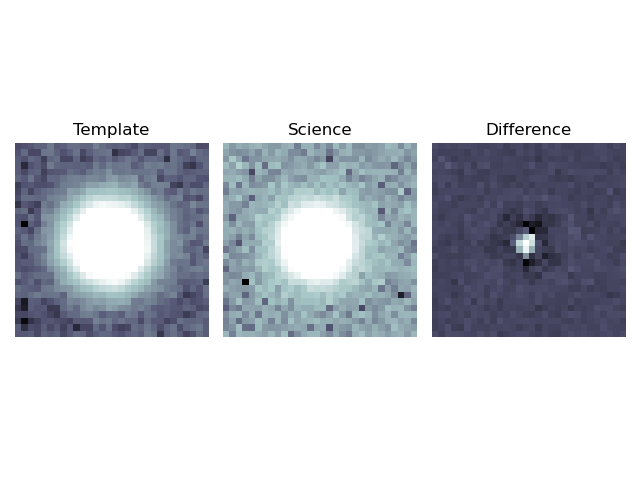

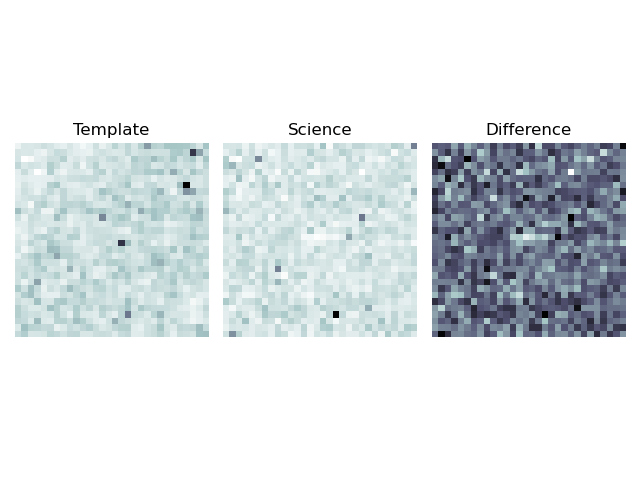

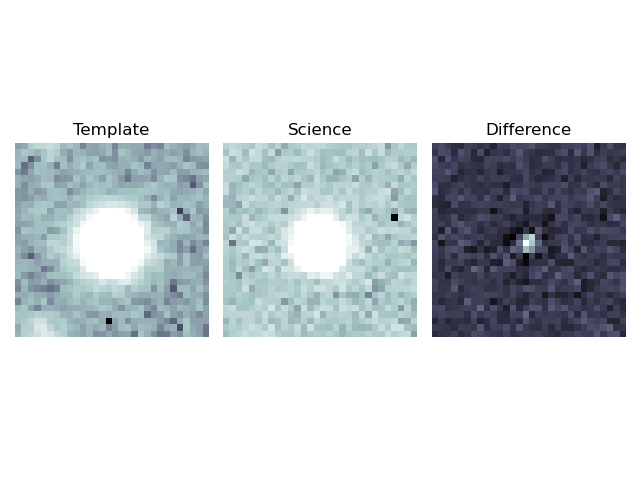

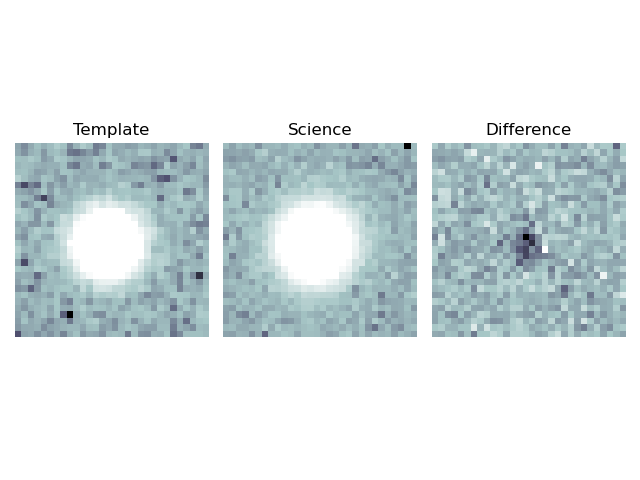

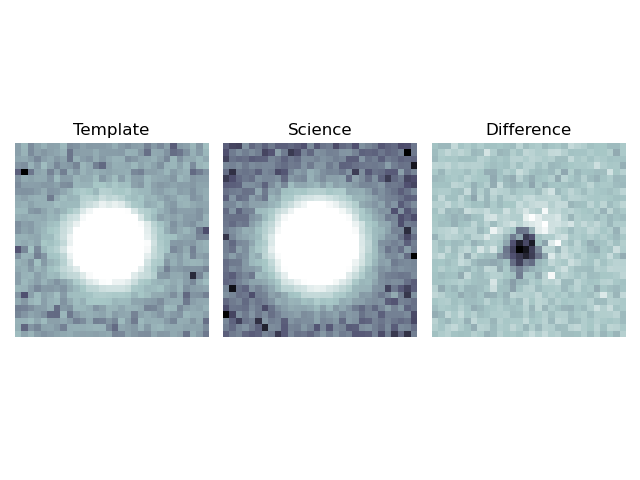

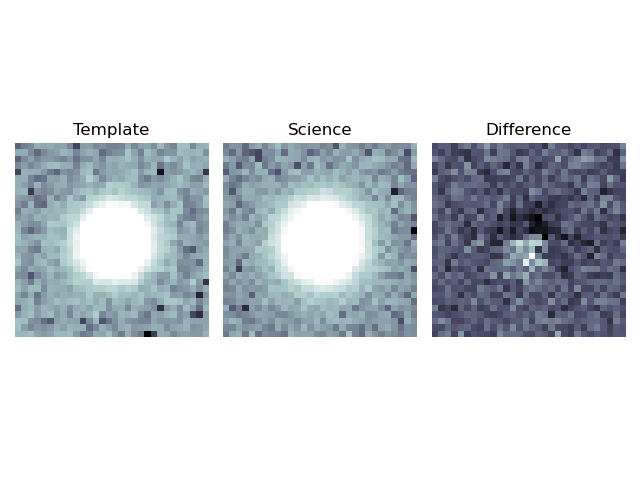

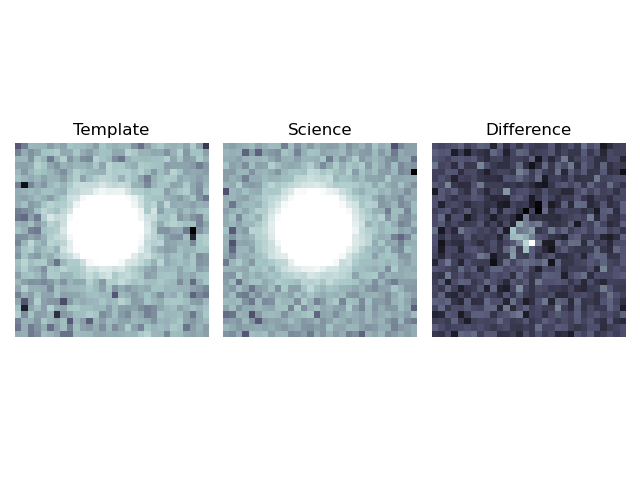

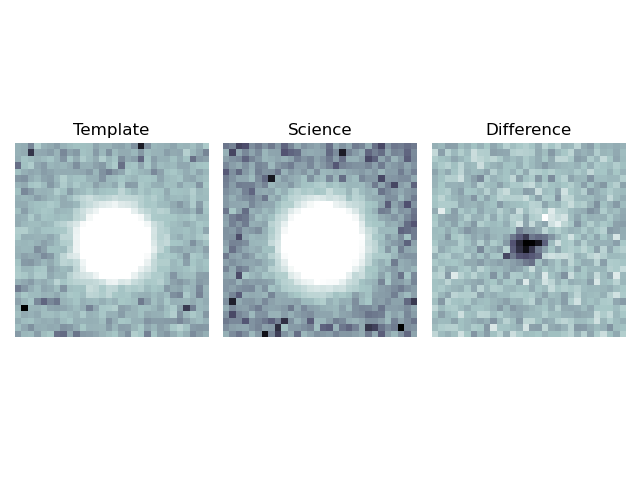

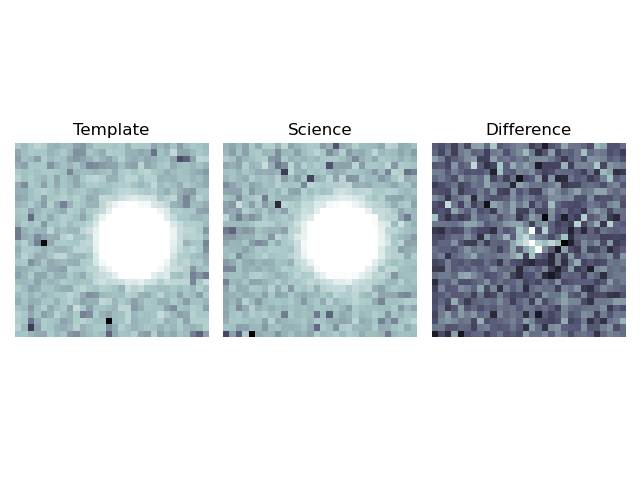

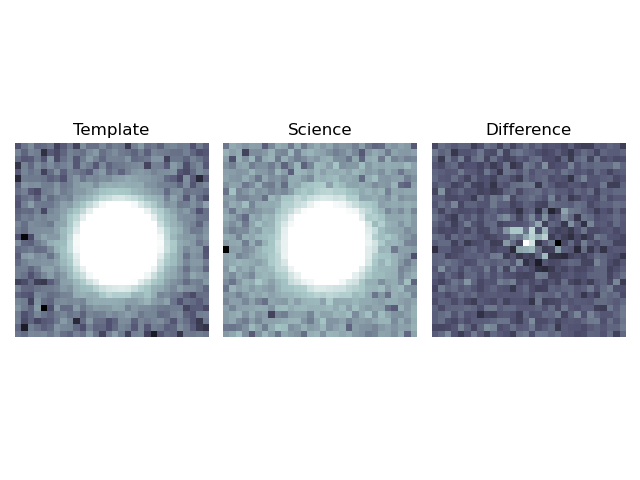

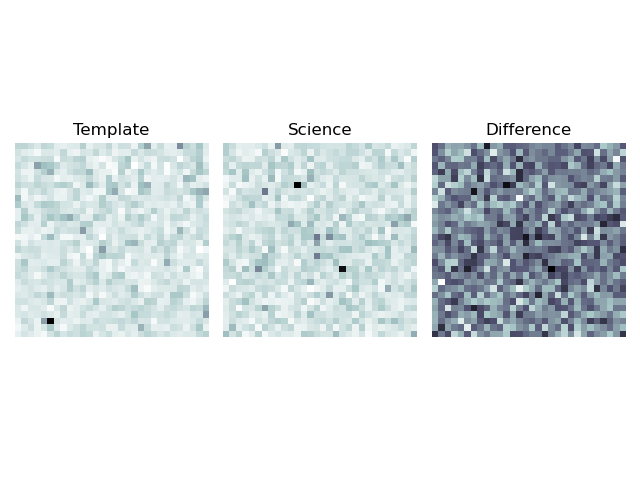

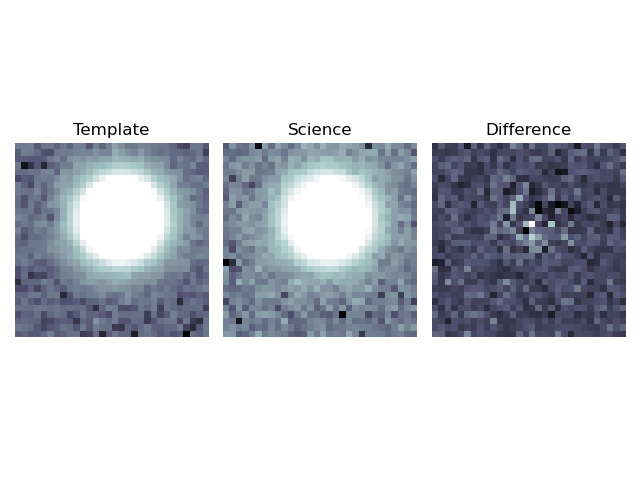

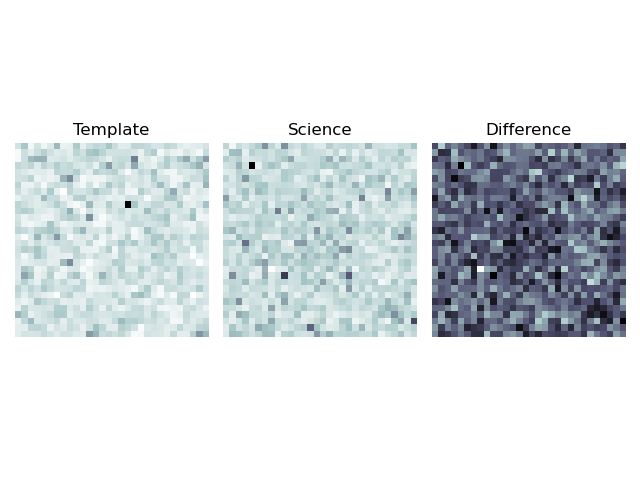

In [28]:
for band in bandList:
    bandGoodSrc = goodSrc.loc[goodSrc['filterName'] == band]
    print(f'{band} band DIA Sources')
    for index, source in bandGoodSrc[:5].iterrows():
        print(bandGoodSrc['diaSourceId'][index])
        dataId = {'detector': int(bandGoodSrc['detector'][index]), 'visit': int(bandGoodSrc['visit'][index]), 'instrument': instrument}
        center = lsst.geom.SpherePoint(bandGoodSrc['ra'][index], bandGoodSrc['decl'][index], lsst.geom.degrees)
        scienceCutout, differenceCutout, templateCutout = legacyPlotUtils.retrieveCutouts(butler, dataId, collections, center, diffName='goodSeeing')
        legacyPlotUtils.plotCutout(scienceCutout, differenceCutout, templateCutout)